## Biodiversity Intactness Index change in Phoenix, AZ

Author : Joaquin Sandoval 

Link to GitHub repository: https://github.com/sandovaljoaquin/biodiversity-intactness-index-change

## About

The purpose of this notebook is to explore the impacts of urban expansion in the Pheonix area on biodiversity. 

### Highlights: 

- Retrieving data from Microsoft Planetary Computer SpatioTemporal Asset Catalog (STAC). 
- Clipping data to the boundary of Houston subdivison 
- Calculating the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in  2017 and 2020. 
- Calculating the area with BII>=0.75 in 2017 that was lost by 2020.
- Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020.


### About the data: 

[1] Biodiversity Intactness Index (BII) Time Series collection from the Microsoft Planetary Computer STAC catalog. Contains raster data from 2017-2020. 

[2] County subdivision shapefiles for Arizona. County subdivisions are the primary divisions of counties and equivalent entities for the reporting of Census Bureau data.

### References

[1] 
Microsoft Planetary Computer. (2025). IO biodiversity dataset. https://planetarycomputer.microsoft.com/dataset/io-biodiversity

[2] 
U.S. Census Bureau. (2025). *TIGER/Line shapefile – Current state: Arizona, county subdivision*. https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision 

Import necessary libraries.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import geopandas as gpd
import rioxarray as rioxr
from shapely import box
import contextily as ctx

import pystac_client
import planetary_computer

from IPython.display import Image 

Arizona county subdivision shapefiles were imported and filtered to isolate the Phoenix subdivision.

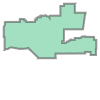

In [2]:
# Import shapefile

fp = os.path.join('data', 'tl_2025_04_cousub', 'tl_2025_04_cousub.shp')
counties = gpd.read_file(fp)

counties.columns = (counties.columns                # Clean to lower snake case 
                    .str.lower()             
                    .str.replace(' ' , '_'))

pheonix = counties[counties['name'] == 'Phoenix']   # Subset to Pheonix subdivison
pheonix_polygon = pheonix.geometry.iloc[0]
pheonix_polygon                                     # Verify shape is correct 

A map was created to show the Phoenix subdivision within its broader geographic context, layered over a base map imported from OpenStreetMap contributors.

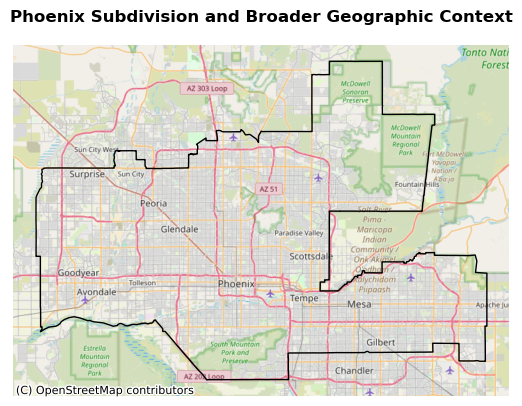

In [3]:
pheonix = pheonix.to_crs(epsg=3857)

fig, ax = plt.subplots()  

pheonix.plot(ax = ax, 
             color = 'none' ,
             edgecolor='black')

ax.set_title("Phoenix Subdivision and Broader Geographic Context", 
             fontweight = "bold") 
# Remove axes labels
# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.axis("off")
plt.show()

## Retrieving data from Microsoft Planetary Computer SpatioTemporal Asset Catalog (STAC). 

When conducting a STAC search, it is necessary to define a bounding box that spatially constrains the catalog query. This bounding box limits the search to the geographic area of interest, ensuring that only relevant assets within the specified extent are returned. The following limit will be utilized : [-112.826843, 32.974108, -111.184387, 33.863574].

The Biodiversity Intactness Index `io-biodiversity` collection can also be accessed from the catalog by retrieving it as a child object and assigning it to `io_collection`. This step allows subsequent operations such as spatial searches, temporal filtering, and asset selection to be performed on this specific collection.


In [4]:
# Bounding‑box coordinates for catalog search (minx, miny, maxx, maxy)

bbox_coords = [-112.826843, 32.974108, -111.184387, 33.863574]
bbox_coords

[-112.826843, 32.974108, -111.184387, 33.863574]

In [5]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# View collection
io_collection = catalog.get_child('io-biodiversity')
io_collection

<CollectionClient id=io-biodiversity>

The MPC catalog will be queried for the `io-biodiversity` collection using specified bounding box coordinates. This spatial constraint will ensure that the search returned is biodiversity data intersecting the area of interest.

In [6]:
# Search MPC catalog 
search = catalog.search(collections= ['io-biodiversity'], 
                        bbox = bbox_coords)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


Four raster layers are returned, one for each year 2017 – 2020. Select a year by indexing the list in reverse order:

[3] = 2017

[2] = 2018

[1] = 2019

[0] = 2020

The chosen raster can be into an `xarray.DataArray` with `rioxr.open_rasterio`

In [7]:
# Select unique search item for 2017
bii_2017 = items[3]
# Loading 2017 raster data using open_rasterio()
bii_2017 = rioxr.open_rasterio(bii_2017.assets['data'].href)
bii_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [8]:
# Select unique search item for 2020
bii_2020 = items[0]
# Loading 2020 raster data using open_rasterio()
bii_2020 = rioxr.open_rasterio(bii_2020.assets['data'].href)
bii_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Now two rasters and a shapefile are being handled, each with its own coordinate reference system. Before any analysis can be done, the CRS of all three layers must be aligned.

In [9]:
 #Convert the pheonix shapefile CRS to the bii raster CRS and verify update 

pheonix_match = pheonix.to_crs(bii_2017.rio.crs)
assert pheonix_match.crs == bii_2017.rio.crs 

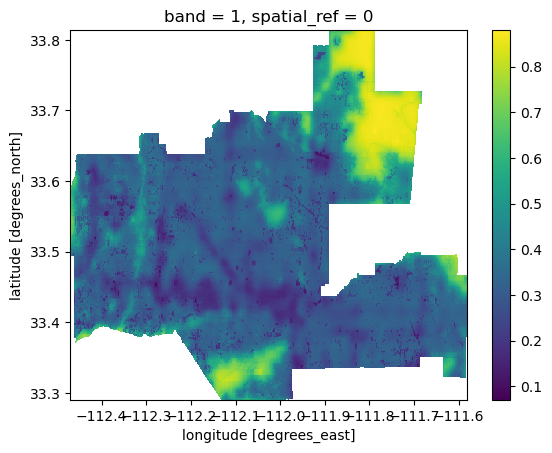

In [10]:
# Clip large 2017 raster to detailed geometry in two steps 

bii_2017_clip = (bii_2017.rio.clip_box(*pheonix_match.total_bounds)
                 .rio.clip(pheonix_match.geometry)
                 )

# Examine results
bii_2017_clip.plot()   

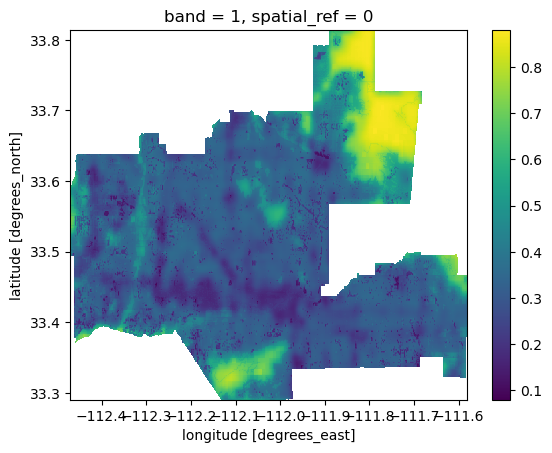

In [11]:
# Clip large 2020 raster to detailed geometry in two steps 

bii_2020_clip = (bii_2020.rio.clip_box(*pheonix_match.total_bounds)
                 .rio.clip(pheonix_match.geometry)
                 )

# Examine results
bii_2020_clip.plot()  

## Calculating the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in  2017 and 2020

The following code evaluates how much of the Phoenix Subdivision retains high biodiversity intactness in each year. Boolean masks are used to mark every pixel with a BII value ≥ 0.75; then the total number of valid pixels in the reference raster is counted and the proportion of the area that meets the high‑BII threshold for each year is calculated.

In [ ]:
# Create Boolean masks for values of BII greater than or equal to 0.75
bii_2017_high = bii_2017_clip >= 0.75
bii_2020_high = bii_2020_clip >= 0.75

# Obtain total valid pixels from the original bii_2017 object as reference and exclude null data
total_pixels = bii_2017_clip.notnull().sum()

# Obtain pixel counts of BII reater than or equal to 0.75 in 2017, 2020, and the difference 
pixels_2017   = bii_2017_high.sum()
pixels_2020   = bii_2020_high.sum()

# Divide each # of pixels (>= .75) by total number of pixels and convert to percentages 
pct_2017 = (pixels_2017 / total_pixels) * 100
pct_2020 = (pixels_2020 / total_pixels) * 100

# Print to two decimals 
print(f"Percent area of Phoenix Subdivision with BII ≥ 0.75 in 2017: {pct_2017.item():.2f}%")
print(f"Percent area of Phoenix Subdivision with BII ≥ 0.75 in 2020: {pct_2020.item():.2f}%")

Percent area of Phoenix Subdivision with BII ≥ 0.75 in 2017: 7.13%
Percent area of Phoenix Subdivision with BII ≥ 0.75 in 2020: 6.49%


Boolean masks plotted for each year reveal subtle changes in BII. 

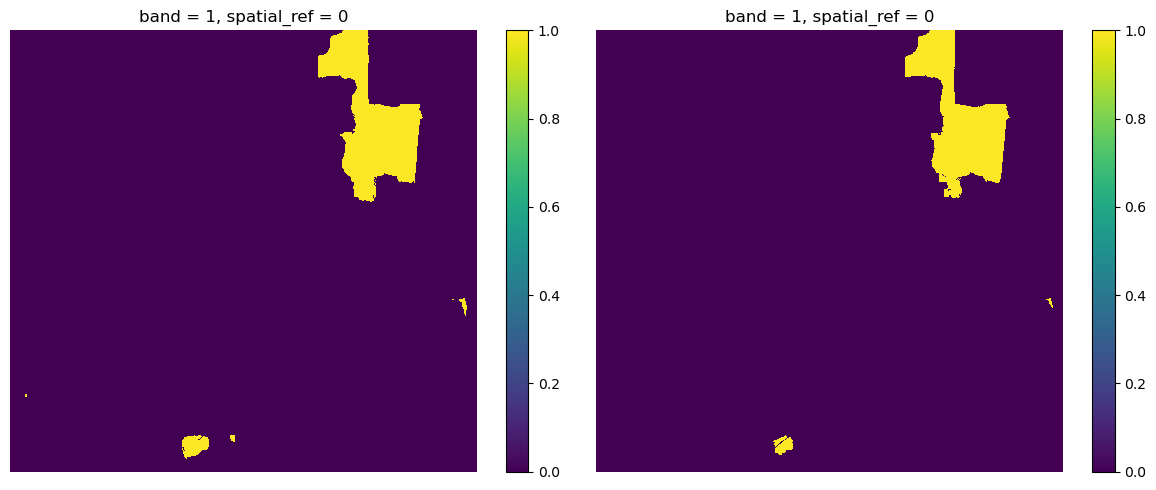

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bii_2017_high.plot(ax=ax1)
bii_2020_high.plot(ax=ax2)

ax1.axis("off")
ax2.axis("off")

plt.tight_layout()
plt.show()

## Calculating the area with BII>=0.75 in 2017 that was lost by 2020.

The same methods described above are utilized to calculate the percent change from 2017 to 2020.

In [ ]:
# Obtaining the pixels of high BII that were lost from 2017 to 2020
difference = bii_2017_high != bii_2020_high          
# Visual mask for plotting
difference_mask = difference.where(difference, other=np.nan)

#Obtain pixel counts of BII reater than or equal to 0.75 in 2017, 2020, and the difference 
pixels_change = difference.sum()

# Divide each # of pixels (>= .75) by total number of pixels and convert to percentages 
pct_diff = (pixels_change / total_pixels) * 100

# Print to two decimals 
print(f"Percent area change of BII ≥ 0.75 from 2017‑2020: {pct_diff.item():.2f}%")

Percent area change of BII ≥ 0.75 from 2017‑2020: 0.66%


This difference in 0.66% can be visualized. 

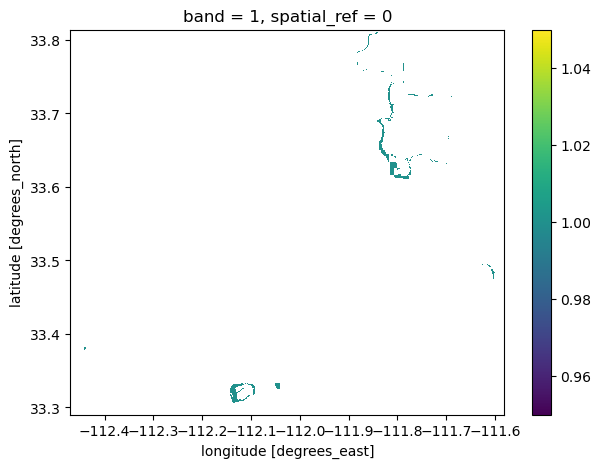

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))  

difference_mask.plot(ax = ax)


## Visualization showing the area with BII>=0.75 in 2017 that was lost by 2020.
Plot the 2020 Biodiversity Intactness Index (BII) Phoenix Subdivision and area with BII greater than 0.75 lost from 2017. 

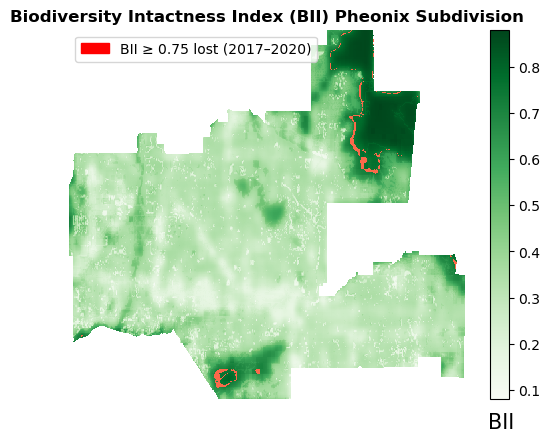

In [13]:
# Plot
fig, ax = plt.subplots()  

bii_2020_clip.plot(
    ax=ax, 
    cmap = 'Greens')

difference_mask.plot(ax = ax, 
                  cmap = 'Reds',
                  add_colorbar = False)

loss_patch = mpatches.Patch(
    color="red",
    label="BII ≥ 0.75 lost (2017–2020)")

ax.legend(
    handles=[loss_patch],
    loc="upper left",
    frameon=True)

ax.set_title("Biodiversity Intactness Index (BII) Pheonix Subdivision", 
             fontweight = "bold")  
fig.text(0.78, 0.05,
         "BII", 
         fontsize = 15)

# Remove axes labels
ax.axis("off")
plt.show()

The final visualization shows the 2020 Biodiversity Intactness Index (BII) and highlights the area where BII ≥ 0.75 was lost between 2017 and 2020 (shaded in red). In reference to the “Phoenix Subdivision and Broader Geographic Context” map, the regions experiencing BII declines are:

- **South Mountain Park Preserve** to the south, and  
- **McDowell Regional Park** and **McDowell Sonoran Preserve** in the northwest.

These losses are most likely linked to rapid urban expansion along the park boundaries, which threatens local biodiversity as human development encroaches on these protected areas.